# Black Friday sales prediction 2023

this notebook is the continuation of the work from the other notebook, it contains the second part of the study project of black friday sales data.

**Goal:** predict the purshase amount in Black Friday against several customer demographics and various product details.

### The project pipeline
 1. ✅look at the big picture
 2. ✅get the data
 3. ✅discover the dataset
 4. ✅visualise & analyse the data to get insights
 5. ⌛preprocess the data for ML algorithmes
 6. ⌛model selection
 7. ⌛fine tune the model
 8. ⌛deploy the model


### import the dataset


In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

black_df = pd.read_csv("datasets/Black_data.csv")

in the last notebook we did some exploration of some statistics in the dataset, so we start doing data preprocessing direcly

In [176]:
black_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


## Data preprocessing

we will do:
- data cleaning
- change the categorical columns into numerical
- drop unusefull features
- split the data into train and test

### data cleaning

first, some features like "User_ID" and "Product_ID" are irrelevant in our regression problem, so wedrop it.

In [177]:
black_df.drop(["User_ID", "Product_ID"], axis=1, inplace=True)

In [178]:
black_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      550068 non-null  object 
 1   Age                         550068 non-null  object 
 2   Occupation                  550068 non-null  int64  
 3   City_Category               550068 non-null  object 
 4   Stay_In_Current_City_Years  550068 non-null  object 
 5   Marital_Status              550068 non-null  int64  
 6   Product_Category_1          550068 non-null  int64  
 7   Product_Category_2          376430 non-null  float64
 8   Product_Category_3          166821 non-null  float64
 9   Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 42.0+ MB


fortunately, most of the columns doesn't have any missing values. but the two columns "Product_Category_2" and "Product_Category_3" have many missing values

In [179]:
# calculate the % if missing values in the two colunmns
data = {
    "attribute": ["Product_Category_2", "Product_Category_3"],
    "% of missing values": [round(black_df["Product_Category_2"].isnull().sum() / black_df.shape[0] * 100, 2),
                            round(black_df["Product_Category_3"].isnull().sum() / black_df.shape[0] * 100, 2)]
}
missing_values = pd.DataFrame(data=data)
missing_values

,attribute,% of missing values
0,Product_Category_2,31.57
1,Product_Category_3,69.67


Here is the strategy:
- we imput the column "	Product_Category_2" with the median value of the entier column
- we drop the entier column "Product_Category_3" because it has large percentage of missing values

In [180]:
black_df.drop("Product_Category_3", axis=1, inplace=True)

In [181]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
product_Category_2_imputed = imputer.fit_transform(black_df[["Product_Category_2"]])
black_df["Product_Category_2"] = product_Category_2_imputed

### Removing outliers

In [182]:
# Calculate the interquartile range (IQR)
q1 = black_df['Purchase'].quantile(0.25)
q3 = black_df['Purchase'].quantile(0.75)
iqr = q3 - q1

# Set the lower and upper bounds for outliers
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr

# Remove outliers from the DataFrame
black_df = black_df.loc[(black_df['Purchase'] > low) & (black_df['Purchase'] < high)]

# Reset the index of the cleaned DataFrame
black_df.reset_index(drop=True, inplace=True)

In [183]:
black_df

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,F,0-17,10,A,2,0,3,9.0,8370
1,F,0-17,10,A,2,0,1,6.0,15200
2,F,0-17,10,A,2,0,12,9.0,1422
3,F,0-17,10,A,2,0,12,14.0,1057
4,M,55+,16,C,4+,0,8,9.0,7969
...,...,...,...,...,...,...,...,...,...
547386,M,51-55,13,B,1,1,20,9.0,368
547387,F,26-35,1,C,3,0,20,9.0,371
547388,F,26-35,15,B,4+,1,20,9.0,137
547389,F,55+,1,C,2,0,20,9.0,365


### Handling Text and Categorical Attributes

In [184]:
for feature in black_df:
    if len(black_df[feature].unique()) < 25:
        print(feature, black_df[feature].unique())

Gender ['F' 'M']
Age ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Occupation [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
City_Category ['A' 'C' 'B']
Stay_In_Current_City_Years ['2' '4+' '3' '1' '0']
Marital_Status [0 1]
Product_Category_1 [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19]
Product_Category_2 [ 9.  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12. 10. 17. 13.  7. 18.]


it seems that almost all the attributes are categorical, so we need to encode them into nmerical values for machine learning algorithmes

before encoding it, we constat the there is two types of categorical attributes.
- the first is  ordered categories such as "Age", "Stay_In_Current_City_Years" when we can sort its values.
- the second is non ordered categories when its can't be ordered in a specific order.

so we need to handle both of them separately, the reason is that in the unordered categories the machine learning algorithme will assume that two nearby encoded values are similar but they actually totally independants.

In [185]:
ordered_attr = ["Age", "Stay_In_Current_City_Years"]
unordered_attr = ['Gender', 'Occupation', 'City_Category', 'Marital_Status', 'Product_Category_1', 'Product_Category_2']

I will use the ordinal encoder to encode the ordered categories

In [186]:
from sklearn.preprocessing import OrdinalEncoder

# function to encode the ordered attributes in the Dataframe
def encodeOrderedAttributes(df, ordered_attr):
    # encode the attributes
    ord_encoder = OrdinalEncoder()
    cat_encoded = ord_encoder.fit_transform(df[ordered_attr])

    # return the new dataframe with encoded attributes
    return pd.DataFrame(cat_encoded, columns=ordered_attr)

# example
encodeOrderedAttributes(black_df, ordered_attr)

,Age,Stay_In_Current_City_Years
0,0.0,2.0
1,0.0,2.0
2,0.0,2.0
3,0.0,2.0
4,6.0,4.0
...,...,...
547386,5.0,1.0
547387,2.0,3.0
547388,2.0,4.0
547389,6.0,2.0


I will use OneHotEncoder to encode the unordered categories

In [187]:
from sklearn.preprocessing import OneHotEncoder


# function to encode the uordered attributes in the Dataframe
def encodeUnorderedAttributes(df, unordered_attr):
    # encode the attributes
    hot_encoder = OneHotEncoder()
    cat_encoded = hot_encoder.fit_transform(df[unordered_attr])
    cat_encoded = cat_encoded.toarray()

    # return new dataframe with encoded attributes
    # create the new columns list
    columns = []
    for attribute, category in zip(unordered_attr, hot_encoder.categories_):
        attributeCategories = [f'{attribute}({str(cat)})' for cat in category]
        columns.extend(attributeCategories)

    # the dataframe
    return pd.DataFrame(data=cat_encoded, columns=columns)


# example
encodeUnorderedAttributes(black_df, unordered_attr)

,Gender(F),Gender(M),Occupation(0),Occupation(1),Occupation(2),Occupation(3),Occupation(4),Occupation(5),Occupation(6),Occupation(7),...,Product_Category_2(9.0),Product_Category_2(10.0),Product_Category_2(11.0),Product_Category_2(12.0),Product_Category_2(13.0),Product_Category_2(14.0),Product_Category_2(15.0),Product_Category_2(16.0),Product_Category_2(17.0),Product_Category_2(18.0)
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547386,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
547387,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
547388,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
547389,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


this function encode the whole dataframe by combining the two last functions together

In [188]:
def encode(df, ordered_attr, unordered_attr):
    ordered_cat = encodeOrderedAttributes(df, ordered_attr)
    unordered_cat = encodeUnorderedAttributes(df, unordered_attr)
    return pd.concat([ordered_cat, unordered_cat], axis=1)

# example
encode(black_df, ordered_attr, unordered_attr)

,Age,Stay_In_Current_City_Years,Gender(F),Gender(M),Occupation(0),Occupation(1),Occupation(2),Occupation(3),Occupation(4),Occupation(5),...,Product_Category_2(9.0),Product_Category_2(10.0),Product_Category_2(11.0),Product_Category_2(12.0),Product_Category_2(13.0),Product_Category_2(14.0),Product_Category_2(15.0),Product_Category_2(16.0),Product_Category_2(17.0),Product_Category_2(18.0)
0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,6.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547386,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
547387,2.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
547388,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
547389,6.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we are ready to encode the whole dataframe to be ready for machine lraning algorithm

In [189]:
df = encode(black_df, ordered_attr, unordered_attr)
df.head()

,Age,Stay_In_Current_City_Years,Gender(F),Gender(M),Occupation(0),Occupation(1),Occupation(2),Occupation(3),Occupation(4),Occupation(5),...,Product_Category_2(9.0),Product_Category_2(10.0),Product_Category_2(11.0),Product_Category_2(12.0),Product_Category_2(13.0),Product_Category_2(14.0),Product_Category_2(15.0),Product_Category_2(16.0),Product_Category_2(17.0),Product_Category_2(18.0)
0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,6.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Features scaling
Our data are well scaled, all attributes ranging between two small values (most cases between 0 and 1). so, no need to scaling it

### Split the data into train and test sets

In [190]:
from sklearn.model_selection import train_test_split

X = df
y = black_df["Purchase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [191]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((492651, 67), (54740, 67), (492651,), (54740,))

## Model selection

#### Linear regression

In [192]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [193]:
from sklearn.metrics import mean_squared_error

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
train_MSE = mean_squared_error(y_train, y_train_pred)
test_MSE = mean_squared_error(y_test, y_test_pred)

lr_train_RMSE = np.sqrt(train_MSE)
lr_test_RMSE = np.sqrt(test_MSE)


print(f'train RMSE: {lr_train_RMSE}\ntest RMSE: {lr_test_RMSE}')

train RMSE: 2984.6166426505097
test RMSE: 2988.203684740162


Let's try with the two variants of Linear regression, **Ridge** and **Lasso** Regressors

#### Ridge Regressor

In [194]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge()
lasso = Lasso()

In [195]:
ridge = Ridge()
ridge.fit(X_train, y_train)

y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)
ridge_train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
ridge_test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))


print(f'train RMSE: {ridge_train_RMSE}\ntest RMSE: {ridge_test_RMSE}')

train RMSE: 2984.5934799072106
test RMSE: 2988.2100628153253


#### Lasso regressor

In [42]:
lasso = Lasso()
lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
lasso_train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
lasso_test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'train RMSE: {lasso_train_RMSE}\ntest RMSE: {lasso_test_RMSE}')

train RMSE: 2985.806714901427
test RMSE: 2989.896005879615


C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e+10, tolerance: 1.200e+09
  model = cd_fast.enet_coordinate_descent(


### Some Ensemble learning alrogithmes

In many cases the ensemble learning algorithmes perform better that a single learner, let's try with some ensemble methods like **RandomForest**, **GradientBoosting** and **XGBoost** regressors

#### Random forest

as the random forest is much sensitive of the dataset length, more the data is large more the RandomForest algorithme is slower, so we will  try to train it on a sample of small dataset.

**Note that** the model will not train as well as if it trained on the whole dataset

In [52]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
X_train_samples = X_train.sample(50000, random_state=42)
y_train_samples = y_train.sample(50000, random_state=42)
forest.fit(X_train_samples, y_train_samples)

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
forest_train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
forest_test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))


print(f'train RMSE: {forest_train_RMSE}\ntest RMSE: {forest_test_RMSE}')

train RMSE: 3080.5458136516045
test RMSE: 3177.534316301035


#### Gradient Boosting Regressor

the Gradient Boosting Regressor also perform slower with large dataset, so we will sample the data

In [53]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
X_train_samples = X_train.sample(50000, random_state=42)
y_train_samples = y_train.sample(50000, random_state=42)
gbr.fit(X_train_samples, y_train_samples)

y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)
gbr_train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
gbr_test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))


print(f'train RMSE: {gbr_train_RMSE}\ntest RMSE: {gbr_test_RMSE}')

train RMSE: 3011.595486181615
test RMSE: 3018.0284886754785


#### The XGBoost Regressor

In [196]:
from xgboost import XGBRegressor

xgb = XGBRegressor(booster='gbtree', n_estimator=300, learning_rate=0.45, reg_lambda=1, reg_alpha=0.05)
xgb.fit(X_train, y_train)

y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
xgb_train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
xgb_test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))


print(f'train RMSE: {xgb_train_RMSE}\ntest RMSE: {xgb_test_RMSE}')

train RMSE: 2858.8321260408516
test RMSE: 2903.880083352924


### Models evaluation comparaison

let's compare all models's train_RMSE and test_RMSE

In [57]:
models_evaluations = {
    'Train_RMSE': [lr_train_RMSE, ridge_train_RMSE, lasso_train_RMSE, forest_train_RMSE, gbr_train_RMSE, xgb_train_RMSE],
    'Test_RMSE': [lr_test_RMSE, ridge_test_RMSE, lasso_test_RMSE, forest_test_RMSE, gbr_test_RMSE, xgb_test_RMSE]
}
models = ['Linear regression', 'Ridge regression', 'Lasso Regression', 'Random forest', 'GradientBoosting regression', 'XGBoost regression']

models_comparaison_df = pd.DataFrame(data=models_evaluations, index=models)
models_comparaison_df

,Train_RMSE,Test_RMSE
Linear regression,2984.616643,2988.203685
Ridge regression,2984.593480,2988.210063
Lasso Regression,2985.806715,2989.896006
Random forest,3080.545814,3177.534316
GradientBoosting regression,3011.595486,3018.028489
XGBoost regression,2886.723868,2917.738341


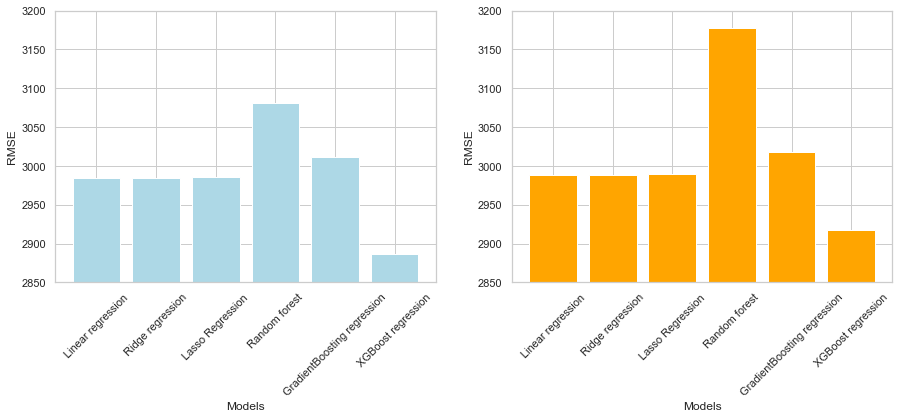

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax0 = axes[0]
ax0.bar(models_comparaison_df.index, height=models_comparaison_df['Train_RMSE'], color='lightblue')
ax0.set_xlabel('Models')
ax0.set_ylabel('RMSE')
ax0.set_xticklabels(models_comparaison_df.index, rotation=45)
ax0.set_ylim([2850,3200])

ax1 = axes[1]
ax1.bar(models_comparaison_df.index, height=models_comparaison_df['Test_RMSE'], color='orange')
ax1.set_xlabel('Models')
ax1.set_ylabel('RMSE')
ax1.set_xticklabels(models_comparaison_df.index, rotation=45)
ax1.set_ylim([2850,3200])

plt.show()

- The two plots shows that the XGBoost model make the best RMSE in both training and test set.
- the random forest and GradientBoosting made a relatively big RMSE, because they wasn't trained with the whole dataset.
- Linear, Ridge and Lasso regression models made almost the same RMSE. but the big point is that each one made almost the same score in both training and testing sets which indicate that they well learned from the data (no over-fitting, no under-fitting).

**Conclusion:** we will choose the XGBRegressor to fine tune it

### Fine tune the model

At this step we need to make the best learning of the XGBoost model, by finding the best combination of hyperparameters.
For that I thought to use GridSearch with many possible values of each hyperparameter to find the best combination

the hyperparameter **n_estimators** specify how many estimator the ensemble will train, so more the n_estimator is large more the training will be computationaly expensive. for that I tought to try to find the best value for this parameter separately of the other combinations of parameters (just to avoid the fitting time of the GridSearch)

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300, 400, 500],    
}

grid = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=2)
grid.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'n_estimators': [200, 250, 300, 350]},
             scoring='neg_root_mean_squared_error')

In [197]:
print(f"best parameter: {grid.best_params_}, best score: {-grid.best_score_}")

best parameter: {'booster': 'gbtree', 'learning_rate': 0.45, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0.9}, best score: 2890.8415950980007


now we will use GridSEarch with combination of values of the following hyperparamters, and fixing the hyperparameter `n_estimators` in the best values found which is 300: 
- **`booster`**: the estimator the XGB will be based on
- **`learning_rate`**: the learning rate eta
- **`reg_lambda`**: the 'l1' regularisation term lambda
- **`reg_alpha`**: the 'l2' regularisation term alpha

In [198]:
param_grid = {'booster': ['gbtree'], 'n_estimators': [300], 'learning_rate': [0.45, 0.47], 'reg_lambda': [0.85, 0.9, 0.95], 'reg_alpha':[0.08, 0.09]}

grid = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=None)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'booster': ['gbtree'], 'learning_rate': [0.45, 0.47],
                         'n_estimators': [300], 'reg_alpha': [0.08, 0.09],
                         'reg_lambda': [0.85, 0.9, 0.95]},
             scoring='neg_root_mean_squared_error')

In [129]:
grid.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.45,
 'n_estimators': 300,
 'reg_alpha': 0.1,
 'reg_lambda': 0.9}

In [130]:
grid.best_score_

-2890.8415950980007

After tryin many combinations of hyperparameters using the GridSearch we found an even better score with the combination *{'booster': 'gbtree','learning_rate': 0.45,'n_estimators': 300,'reg_alpha': 0.05,'reg_lambda': 1}* so we will try to refit the XGBRegressor with those parameters.

In [158]:
final_xgb = XGBRegressor(booster='gbtree', n_estimator=300, learning_rate=0.45, reg_lambda=0.9, reg_alpha=0.05)
final_xgb.fit(X_train, y_train)

y_train_pred = final_xgb.predict(X_train)
y_test_predict = final_xgb.predict(X_test)
train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"final train RMSE: {train_RMSE}\nfinal test RMSE: {test_RMSE}")

final train RMSE: 2858.0706342047097
final test RMSE: 2917.738341175412


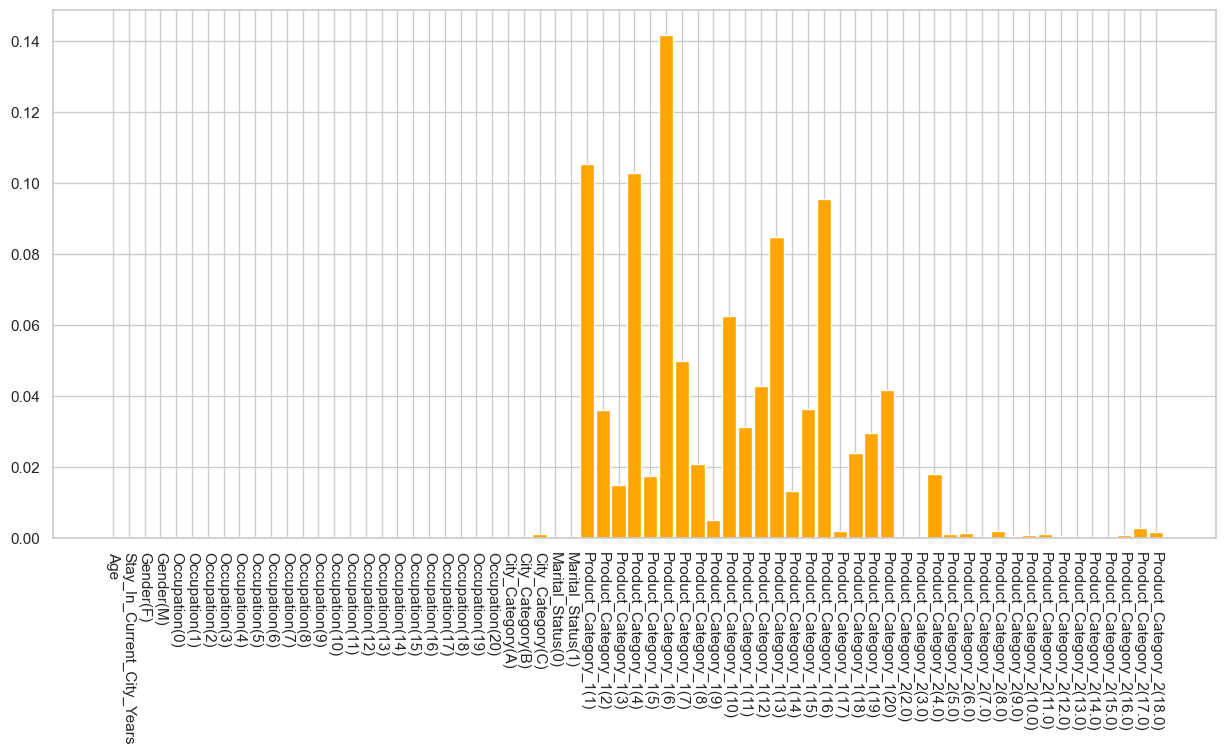

In [153]:
plt.figure(figsize=(15, 7), dpi=100)
plt.bar(xgb.feature_names_in_, xgb.feature_importances_, width=0.9, color='orange')

plt.xticks(rotation=-90)

plt.show()

we constate that the features related with the "Product_Category_1" and "Product_Category_1"